In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
os.listdir()

['run_2_dense_2gb.txt',
 'run_1_dense_4gb.txt',
 'run_7_dense_128mb.txt',
 'run_6_dense_256mb.txt',
 'run_4_dense_512mb.txt',
 'run_10_dense_16mb.txt',
 'run_5_dense_4mb.txt',
 'run_8_dense_64mb.txt',
 'README.md',
 'run_3_dense_1gb.txt',
 'run_9_dense_32mb.txt',
 '.gitignore',
 '.ipynb_checkpoints',
 'm2.csv',
 '.git',
 'M1_and_M2_Regression.ipynb']

In [3]:
def parse_memory(memory):
    num = 0
    if 'gb' in memory:
        num = int(memory.replace('gb', '')) * 1000000000
    if 'mb' in memory:
        num = int(memory.replace('mb', '')) * 1000000
    return num

dfs = {}
for benchmark in os.listdir():
    if benchmark.endswith('.txt'):
        memory = benchmark.split('.')[0].split('_')[-1]
        df = pd.read_csv(benchmark, delimiter=" ", names=['input_size', 'output_size', 'time'])
        df['memory'] = df['time'].apply(lambda _: parse_memory(memory))
        dfs[memory] = df

In [4]:
df = pd.concat(dfs.values())
df.sample(10)

,input_size,output_size,time,memory
22,4,2048,8.42412400246,2000000000
31,8,256,552.594982862,32000000
14,4,8,58.9751250744,32000000
5,2,64,2.10154008865,512000000
21,4,1024,10.6956350803,128000000
11,2,4096,1659.11910486,16000000
19,4,256,1043.67360115,16000000
39,16,16,3.97778916359,512000000
25,8,4,18.5944969654,128000000
13,4,4,593.717950106,16000000


In [5]:
df.loc[36][df.loc[36]['time'] != 'Killed']['memory']

36    2000000000
36    4000000000
36     512000000
36    1000000000
Name: memory, dtype: int64

In [6]:
df.loc[48]

,input_size,output_size,time,memory
48,32,2,Killed,2000000000
48,32,2,5.45444512367,4000000000
48,32,2,Killed,512000000
48,32,2,Killed,1000000000


In [7]:
m1_df = pd.DataFrame(columns=['input_size', 'output_size', 'm_1'])
for idx in set(df.index):
    mem_df = df.loc[idx]
    if isinstance(mem_df, pd.Series):
        mem_df = mem_df.to_frame().transpose()
        if mem_df['time'].iloc[0] == 'Killed':
            continue
        m1 = mem_df['memory'].iloc[0]
    else:
        m1 = min(mem_df[mem_df['time'] != 'Killed']['memory'])
    m1_df = m1_df.append({
        'input_size': mem_df['input_size'].iloc[0],
        'output_size': mem_df['output_size'].iloc[0],
        'm_1': m1
    }, ignore_index=True)
m1_df.head(10)

,input_size,output_size,m_1
0,2,2,4000000
1,2,4,4000000
2,2,8,16000000
3,2,16,16000000
4,2,32,16000000
5,2,64,16000000
6,2,128,16000000
7,2,256,16000000
8,2,512,16000000
9,2,1024,16000000


In [8]:
m1_df.tail(15)

,input_size,output_size,m_1
45,16,1024,512000000
46,16,2048,512000000
47,16,4096,512000000
48,32,2,4000000000
49,32,4,4000000000
50,32,8,4000000000
51,32,16,4000000000
52,32,32,4000000000
53,32,64,4000000000
54,32,128,4000000000


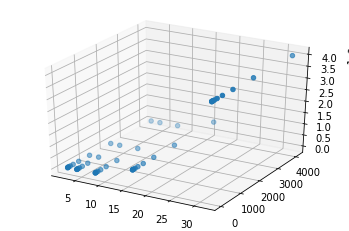

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(m1_df['input_size'], m1_df['output_size'], m1_df['m_1'])

plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso


In [11]:
def random_forest(data, pred_column):
    
    X = data.drop([pred_column], axis=1)  # Features
    y = data[pred_column]  # Labels

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf.fit(X_train, y_train);
    
    
    y_pred = rf.predict(X_test)

    print("MSE:", mean_squared_error(y_test, y_pred))

    test_results = pd.concat([X_test, pd.DataFrame({'actual': y_test, 'pred': y_pred})], axis=1)

    return rf, test_results

In [12]:
m1_regressor, test_results = random_forest(m1_df, 'm_1')

MSE: 5056728000000.0


In [13]:
test_results

,input_size,output_size,actual,pred
34,8,2048,32000000,3.200000e+07
11,2,4096,16000000,1.595200e+07
45,16,1024,512000000,5.120000e+08
39,16,16,512000000,5.120000e+08
56,32,512,4000000000,4.000000e+09
10,2,2048,16000000,1.595200e+07
14,4,8,16000000,1.444000e+07
40,16,32,512000000,5.120000e+08
2,2,8,16000000,7.324000e+06
24,8,2,32000000,3.200000e+07


In [14]:
m2 = pd.read_csv('m2.csv')
m2.head()

m2_df = pd.DataFrame(columns=['input_size', 'output_size', 'm_2'])
for idx in set(df.index):
    mem_df = df.loc[idx]
    if isinstance(mem_df, pd.Series):
        mem_df = mem_df.to_frame().transpose()
    m2_val = m2.iloc[idx]['m_2']
    m2_df = m2_df.append({
        'input_size': mem_df['input_size'].iloc[0],
        'output_size': mem_df['output_size'].iloc[0],
        'm_2': m2_val
    }, ignore_index=True)
#     print(idx)
m2_df.head(10)

,input_size,output_size,m_2
0,2,2,512000000
1,2,4,128000000
2,2,8,64000000
3,2,16,128000000
4,2,32,128000000
5,2,64,128000000
6,2,128,256000000
7,2,256,128000000
8,2,512,128000000
9,2,1024,128000000


In [17]:
m1_regressor, test_results = random_forest(m2_df, 'm_2')

MSE: 5583687909052632.0


In [18]:
test_results

,input_size,output_size,actual,pred
7,2,256,128000000,2.117120e+08
21,4,1024,256000000,2.526720e+08
24,8,2,512000000,4.757120e+08
29,8,64,256000000,2.552320e+08
49,32,4,4000000000,3.993512e+09
60,64,2,4000000000,3.994000e+09
56,32,512,4000000000,3.993024e+09
52,32,32,4000000000,3.993024e+09
26,8,8,512000000,2.280480e+08
19,4,256,256000000,2.543360e+08
